In [116]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import json
import os
import textwrap

from PIL import Image
from PIL.Image import Image as PilImage
import matplotlib.pyplot as plt

In [14]:
import sys 
sys.path.append('..')
import utils.misc as ws
import utils.data_utils
import utils.train_utils
import utils.eval_utils
import utils.mesh
import utils.dataset as d
import models.networks as arch

In [97]:
dataset_dir = "/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/"

object_model = "003_cracker_box_google_16k_textured_scale_1000"

images_dir = os.path.join(dataset_dir, object_model, "images")

split_file = '../experiments/all3_dsdf/split_train.json'

with open(split_file, 'r') as f:
    data_split = json.load(f)

In [19]:
cmap_files, grp_names, grp_pcs, npzs = utils.data_utils.get_instance_filelist(dataset_dir, data_split)

In [51]:
npzs[:3]

['/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/003_cracker_box_google_16k_textured_scale_1000/sdf/fetch_gripper/sdf_graspnum_0.npz',
 '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/003_cracker_box_google_16k_textured_scale_1000/sdf/fetch_gripper/sdf_graspnum_1.npz',
 '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/003_cracker_box_google_16k_textured_scale_1000/sdf/fetch_gripper/sdf_graspnum_2.npz']

In [32]:
# npzs[100].split('/')[-1].split('.')[0].split('_')[-1]
npzs[100].split('/')[-2]


'HumanHand'

In [28]:
idx = 0
path_split = npzs[idx].split('/')
object_model = path_split[-4]

contactmap_dir = os.path.join(dataset_dir, object_model, "contactmap")

In [35]:
training_contact_maps = [] 
# List of filenames to pick up from contactmap dir

In [36]:
# Considering the object model does not change.
for np_file in npzs:
    _path_split = np_file.split('/')
    gripper_name = _path_split[-2]
    grasp_num = _path_split[-1].split('.')[0].split('_')[-1]
    contactmap_file = f"contactmap_graspnum_{grasp_num}.npz"
    training_contact_maps.append(os.path.join(
                            contactmap_dir,
                            gripper_name,
                            contactmap_file))


In [83]:
training_contact_maps[80]

'/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/003_cracker_box_google_16k_textured_scale_1000/contactmap/HumanHand/contactmap_graspnum_0.npz'

In [67]:
# Create a (N,d) arrray of individual contactmaps
# But we might not know d before hand.
# So load the first file and check it out
_dummy_data = np.load(training_contact_maps[0])['heatmap']
print(_dummy_data.shape)

N = len(training_contact_maps)
d = _dummy_data.shape[0]
contact_maps = np.empty((N,d))


(8194,)


In [84]:
def get_actual_idx(training_contact_maps, global_idx):
    _path_split = training_contact_maps[global_idx].split("/")
    return (_path_split[-2], _path_split[-1].split(".")[0].split("_")[-1])

In [68]:
for i, npf in enumerate(training_contact_maps):
    contact_maps[i] = np.load(npf)['heatmap']

In [69]:
contact_maps.shape

(120, 8194)

In [70]:
# Create a N,N distance matrix
# Using scipy cdist

_Y_dist = pdist(contact_maps, metric='cityblock')

In [71]:
_Y_dist.shape

(7140,)

In [72]:
# _Y_dist is a condensed distance matrix.
D = squareform(_Y_dist) 

In [73]:
print(D.shape, np.max(D))

(120, 120) 3163.64562931402


In [74]:
# Normalize to [0,1]
D /= np.max(D)

In [76]:
S = 1 - D

In [95]:
topK_list = np.argsort(D[7])
print(topK_list)

[  7  15  35  29  34  41   1 103  23  20   9  59  99  61  83  92  36  25
 106 118  78  53  55  96  46  84  65  14  60  75  66   3  71  98  57  17
 104  26  81  85  43  62  91  74   5  48 117  94  52  93  45  51 114  42
  76  67 112 113  79  12   2  49  73  44 109 100  63  90  97 102  64  18
  89  70  68   6  22  33  19  38  69  13  88 116  40   8  11 101  56 111
  50  16 119  21  82  87   4  24  37 110  47  10  30 115  58  72  28  39
 108  80  95  27  77  86 105   0  32  31 107  54]


In [124]:
get_actual_idx(training_contact_maps, 27)

('fetch_gripper', '27')

In [125]:
# Reference: https://keestalkstech.com/2020/05/plotting-a-grid-of-pil-images-in-jupyter/

def display_images(
    images: list,
    overall_title,
    columns=6, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):


    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = 1 + max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    plt.title(overall_title)
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

QUERY IMAGE


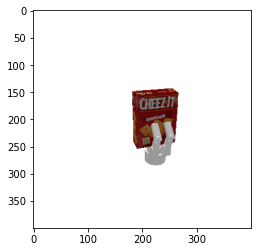

In [159]:
query_idx = 54

query_gripper, query_gnum = get_actual_idx(training_contact_maps, query_idx)
query_img_f = os.path.join(images_dir, query_gripper, f"img_graspnum_{query_gnum}.png")
q_img = Image.open(query_img_f)

topK_query = np.argsort(D[query_idx])

k = 10
top_K_close = []
bot_K_away = []

# 1 to K+1 since 0 index correspnds to the query itself
for i in range(1, k+1):
    gripper, gnum = get_actual_idx(training_contact_maps, topK_query[i])    
    img_f = os.path.join(images_dir, gripper, f"img_graspnum_{gnum}.png")
    top_K_close.append(img_f)
    
    rev_idx = -i
    f_gripper, f_gnum = get_actual_idx(training_contact_maps, topK_query[rev_idx])    
    far_img_f = os.path.join(images_dir, f_gripper, f"img_graspnum_{f_gnum}.png")
    bot_K_away.append(far_img_f)
    
# Populate the PIL images
# _img_tst = Image.open(top_K_close[0])

imgs_close_topK = [Image.open(_img) for _img in top_K_close]

imgs_far_botK = [Image.open(_img) for _img in bot_K_away]

print("QUERY IMAGE")
plt.imshow(q_img)

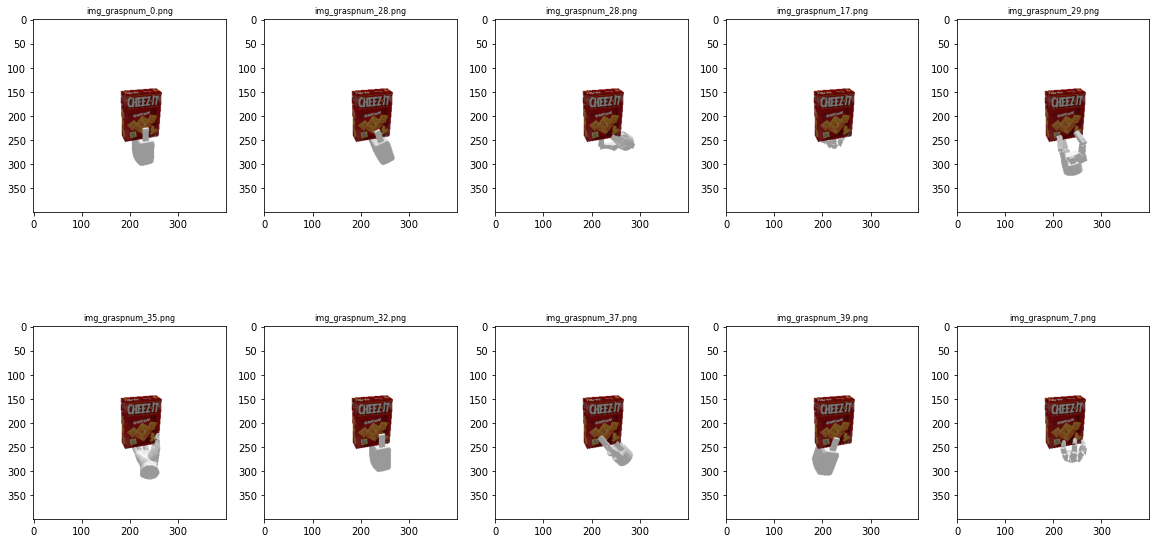

In [160]:
# PLOT THEM!
display_images(imgs_close_topK, overall_title="Closest")

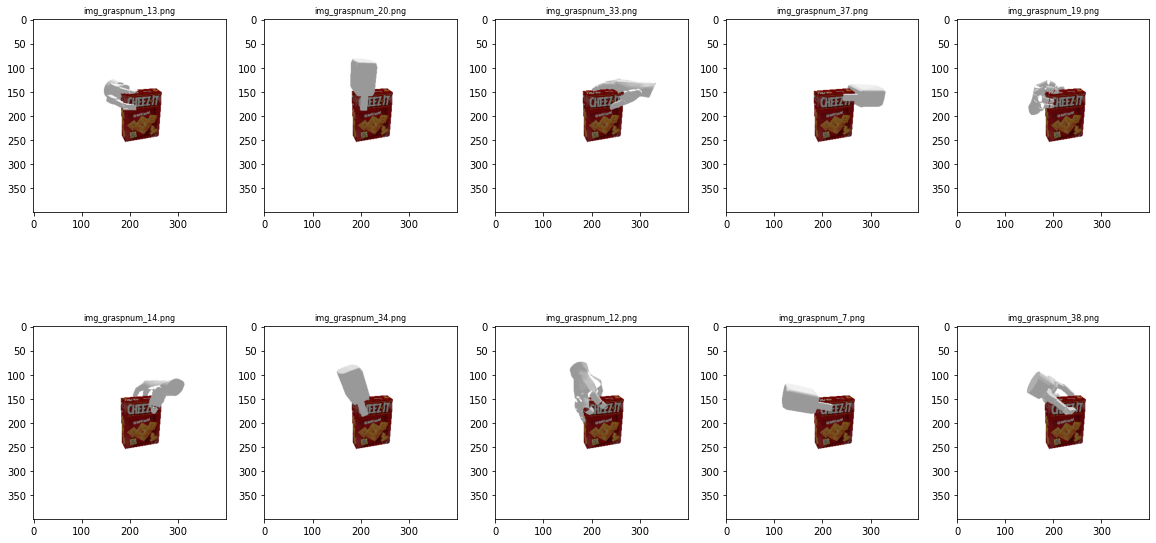

In [161]:
display_images(imgs_far_botK, overall_title="Farthest")